# Imports

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [12]:
path = Path('C:/Users/jpatn/data/camvid_tira/')

In [13]:
image_path = path/'images'
label_path = path/'labels'
valid_path = path/'valid.txt'
weights_path = image_path/'models/best/'
weights2 = Path('D:/programming/projects/camvid/models')

# Data

In [19]:
def open_im(fp):
    return PIL.Image.open(fp)

In [14]:
im_fp = get_image_files(image_path)

In [15]:
lbl_fp = get_image_files(label_path)

In [18]:
get_lbl_fp = lambda x: label_path/f'{x.stem}_P{x.suffix}'

In [28]:
new_codes = ['Building', 'Car', 'Cyclist', 'Fence', 'Pedestrian', 'Pole', 'Road', 'Sidewalk', 
             'Sign', 'Sky', 'Vegetation', 'Void']

# DataBunch

In [22]:
lbl1_data = np.array(open_im(lbl_fp[0])); lbl1_data

array([[ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  0],
       ...,
       [ 7,  7,  7,  7, ..., 11, 11, 11, 11],
       [ 7,  7,  7,  7, ..., 11, 11, 11, 11],
       [ 7,  7,  7,  7, ..., 11, 11, 11, 11],
       [ 7,  7,  7,  7, ..., 11, 11, 11, 11]], dtype=uint8)

In [24]:
src_size = np.array(lbl1_data.shape); src_size

array([720, 960])

In [25]:
def get_data(size, bs):
    return (SegmentationItemList.from_folder(image_path)
            .split_by_fname_file(valid_path)
            .label_from_func(get_lbl_fp, classes=new_codes)
            .transform(get_transforms(),size=size,tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

## Viewing Data

In [29]:
data = get_data(src_size//2,4)

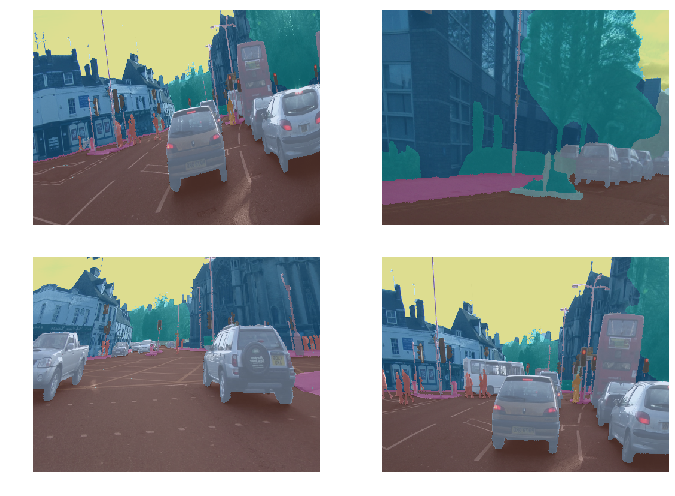

In [30]:
data.show_batch(2,figsize=(10,7))

In [39]:
gc.collect()

11960

# Metrics

In [31]:
name2id = {v:k for k,v in enumerate(new_codes)}
void_code = name2id['Void']

In [32]:
def acc_camvid(input,target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# Model 1

## Train 1

In [37]:
data = get_data(src_size//2,4)

In [48]:
learn_sf = unet_learner(data, models.resnet34, metrics=acc_camvid, 
                     wd=1e-2, bottle=True,
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='1'),
                                 ReduceLROnPlateauCallback,
                                 ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


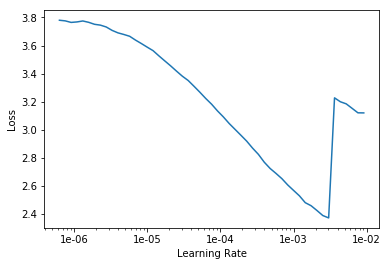

In [49]:
lr_find(learn_sf)
learn_sf.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid
1,0.784596,0.632314,0.850236
2,0.559027,0.510732,0.860783
3,0.502391,0.469505,0.865282
4,0.440571,0.377539,0.884617
5,0.418004,0.368351,0.890133
6,0.371037,0.321614,0.903207
7,0.364592,0.364546,0.889431
8,0.350052,0.318674,0.902963
9,0.325084,0.262620,0.919036
10,0.328715,0.291928,0.915429


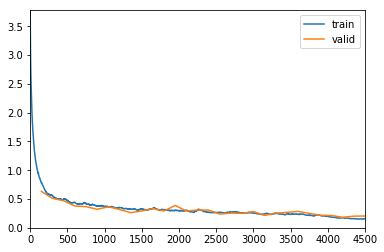

Epoch 7: reducing lr to 4.555890281516281e-05
Epoch 10: reducing lr to 7.915337167015802e-05
Epoch 11: reducing lr to 9.146948554687503e-05
Epoch 12: reducing lr to 0.00010400000000000002
Epoch 13: reducing lr to 0.00011653051445312494
Epoch 14: reducing lr to 0.00012884662832984202
Epoch 15: reducing lr to 0.00014073760950704864
Epoch 16: reducing lr to 0.000152
Epoch 18: reducing lr to 0.00017188225099390856
Epoch 19: reducing lr to 0.0001801619206679586
Epoch 20: reducing lr to 0.00018713843876330615
Epoch 22: reducing lr to 0.00019672887932375055
Epoch 23: reducing lr to 0.00019917870669188583
Epoch 24: reducing lr to 0.0002
Epoch 25: reducing lr to 0.00018660259396828234
Epoch 26: reducing lr to 0.0001500002
Epoch 29: reducing lr to 1.3398206031717641e-05
Epoch 30: reducing lr to 8.000000000000001e-10


In [50]:
learn_sf.fit_one_cycle(30, 1e-3, pct_start=0.8)

## Train 2

In [78]:
learn_su= unet_learner(data, models.resnet34, metrics=acc_camvid, 
                     wd=1e-2, bottle=True,
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='su'),
                                 ReduceLROnPlateauCallback,
                                 ShowGraph])

In [80]:
learn_su.load(weights_path/'1_28').unfreeze();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


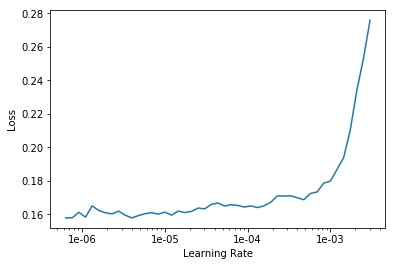

In [81]:
lr_find(learn_su)
learn_su.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid
1,0.164962,0.181531,0.947539
2,0.165519,0.182523,0.946898
3,0.163320,0.185206,0.946123
4,0.160633,0.188640,0.945479
5,0.161082,0.189556,0.945182


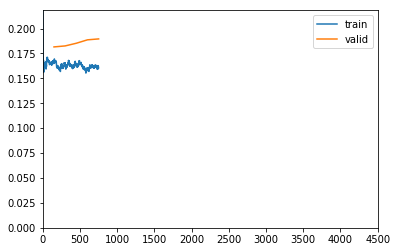

Epoch 2: reducing lr to 1.1271120676249431e-07
Epoch 3: reducing lr to 1.5307564878916472e-07
Epoch 4: reducing lr to 2.0861561236693855e-07
Epoch 5: reducing lr to 2.7838079332041414e-07


KeyboardInterrupt: 

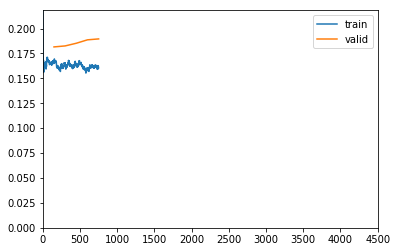

In [82]:
learn_su.fit_one_cycle(30, 1e-5, pct_start=0.8)

In [83]:
gc.collect()

16166

## Train 3

Using full sized images:

In [44]:
data = get_data(src_size,2)

In [45]:
learn_bf = unet_learner(data, models.resnet34, metrics=acc_camvid, 
                     wd=1e-2, bottle=True,
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='bf'),
                                 ReduceLROnPlateauCallback,
                                 ShowGraph])

In [46]:
learn_bf.load(weights_path/'su_1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


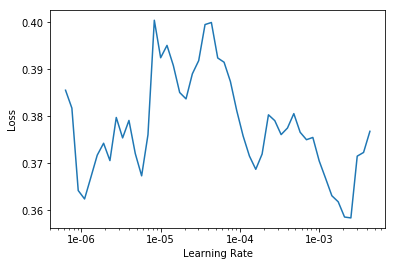

In [48]:
lr_find(learn_bf)
learn_bf.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid
1,0.251979,0.233393,0.933543
2,0.240988,0.226044,0.935153
3,0.225034,0.213286,0.937217
4,0.217202,0.211607,0.940065
5,0.206139,0.210619,0.939826
6,0.206739,0.228894,0.936041
7,0.192820,0.219651,0.936613
8,0.187563,0.209182,0.941051
9,0.194372,0.209100,0.940437
10,0.181598,0.226611,0.941308


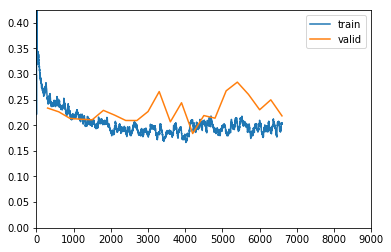

Epoch 6: reducing lr to 3.611774900609144e-05
Epoch 7: reducing lr to 4.555890281516281e-05
Epoch 10: reducing lr to 7.915337167015802e-05
Epoch 11: reducing lr to 9.146948554687503e-05
Epoch 13: reducing lr to 0.00011653051445312494
Epoch 15: reducing lr to 0.00014073760950704864
Epoch 16: reducing lr to 0.000152
Epoch 17: reducing lr to 0.0001624410971848372
Epoch 18: reducing lr to 0.00017188225099390856
Epoch 19: reducing lr to 0.0001801619206679586
Epoch 20: reducing lr to 0.00018713843876330615
Epoch 21: reducing lr to 0.00019269243512108354
Epoch 22: reducing lr to 0.00019672887932375055


KeyboardInterrupt: 

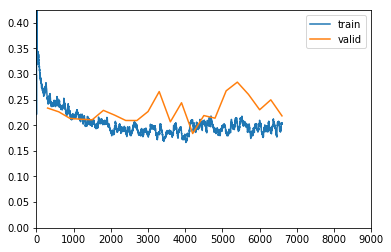

In [49]:
learn_bf.fit_one_cycle(30, 1e-3, pct_start=0.8)

In [50]:
gc.collect()

2224

## Train 4

In [39]:
gc.collect()

4024

In [40]:
data = get_data(src_size,2)

In [41]:
learn_bu = unet_learner(data, models.resnet34, metrics=acc_camvid, 
                     wd=1e-2, bottle=True,
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='bu'),
                                 ReduceLROnPlateauCallback,
                                 ShowGraph])

In [42]:
learn_bu.load(weights_path/'su_1').unfreeze();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


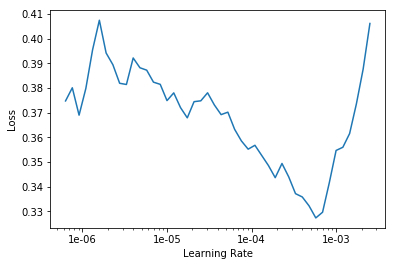

In [43]:
lr_find(learn_bu)
learn_bu.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid
1,0.262501,0.236584,0.933930
2,0.250409,0.219022,0.937611
3,0.222649,0.255425,0.929842
4,0.207589,0.203486,0.938701
5,0.199849,0.224164,0.936625
6,0.201484,0.216784,0.939316
7,0.191137,0.222857,0.938319
8,0.190210,0.213066,0.938601
9,0.191846,0.223835,0.938142
10,0.188703,0.228161,0.937728


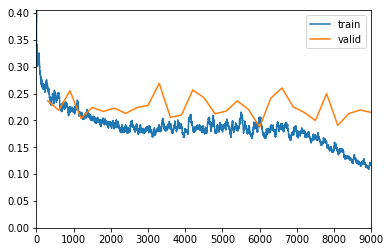

Epoch 3: reducing lr to 1.5307564878916467e-05
Epoch 5: reducing lr to 2.783807933204143e-05
Epoch 6: reducing lr to 3.611774900609144e-05
Epoch 7: reducing lr to 4.555890281516284e-05
Epoch 8: reducing lr to 5.600000000000002e-05
Epoch 9: reducing lr to 6.726239049295139e-05
Epoch 10: reducing lr to 7.915337167015804e-05
Epoch 11: reducing lr to 9.146948554687506e-05
Epoch 12: reducing lr to 0.00010400000000000002
Epoch 13: reducing lr to 0.00011653051445312495
Epoch 14: reducing lr to 0.00012884662832984205
Epoch 15: reducing lr to 0.00014073760950704864
Epoch 16: reducing lr to 0.000152
Epoch 17: reducing lr to 0.00016244109718483723
Epoch 18: reducing lr to 0.00017188225099390862
Epoch 19: reducing lr to 0.00018016192066795862
Epoch 21: reducing lr to 0.0001926924351210836
Epoch 22: reducing lr to 0.0001967288793237506
Epoch 23: reducing lr to 0.00019917870669188586
Epoch 24: reducing lr to 0.00020000000000000006
Epoch 25: reducing lr to 0.0001866025939682824
Epoch 26: reducing lr 

In [44]:
learn_bu.fit_one_cycle(30, slice(1e-6,1e-3), pct_start=0.8)

In [45]:
gc.collect()

489

# Model 2

## Train 1

In [42]:
data = get_data(src_size,2)

In [43]:
learn_b2 = unet_learner(data, models.resnet34, metrics=acc_camvid, 
                     wd=1e-2, bottle=True,
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='b2'),
                                 ReduceLROnPlateauCallback,
                                 ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


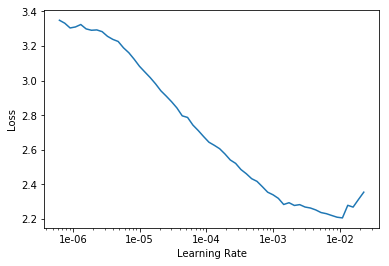

In [51]:
lr_find(learn_b2)
learn_b2.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid
1,0.575223,0.540575,0.851344
2,0.508569,0.409508,0.882937
3,0.423521,0.336090,0.904130
4,0.383277,0.308815,0.905677
5,0.364957,0.331300,0.900764
6,0.357504,0.301079,0.913869
7,0.375916,0.297821,0.919330
8,0.337499,0.308392,0.912373
9,0.321597,0.291655,0.922894
10,0.309578,0.284827,0.918365


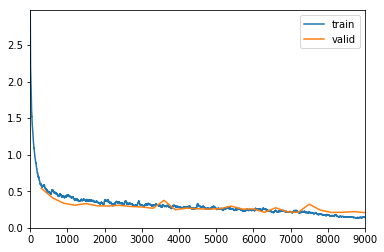

Epoch 5: reducing lr to 2.783807933204143e-05
Epoch 8: reducing lr to 5.6e-05
Epoch 12: reducing lr to 0.00010400000000000002
Epoch 14: reducing lr to 0.00012884662832984202
Epoch 15: reducing lr to 0.00014073760950704864
Epoch 16: reducing lr to 0.000152
Epoch 17: reducing lr to 0.0001624410971848372
Epoch 18: reducing lr to 0.00017188225099390856
Epoch 19: reducing lr to 0.0001801619206679586
Epoch 20: reducing lr to 0.00018713843876330615
Epoch 22: reducing lr to 0.00019672887932375055
Epoch 23: reducing lr to 0.00019917870669188583
Epoch 25: reducing lr to 0.00018660259396828234
Epoch 26: reducing lr to 0.0001500002
Epoch 28: reducing lr to 5.0000600000000024e-05
Epoch 29: reducing lr to 1.3398206031717641e-05


In [44]:
learn_b2.fit_one_cycle(30, slice(1e-5,1e-3), pct_start=0.8)

In [75]:
gc.collect()

338

## Train 2

In [48]:
data = get_data(src_size,2)

In [49]:
learn_b2u = unet_learner(data, models.resnet34, metrics=acc_camvid, 
                     wd=1e-2, bottle=True,
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='2u'),
                                 ReduceLROnPlateauCallback,
                                 ShowGraph])

In [50]:
learn_b2u.load(weights_path/'b2_15').unfreeze()

In [51]:
gc.collect()

589

epoch,train_loss,valid_loss,acc_camvid
1,0.202226,0.216488,0.936969
2,0.195137,0.218159,0.935465
3,0.187797,0.222288,0.936284
4,0.191247,0.216395,0.936107
5,0.185915,0.228992,0.934869
6,0.187008,0.216892,0.938618
7,0.163121,0.216702,0.936331
8,0.179856,0.254060,0.932067
9,0.199759,0.217642,0.940906
10,0.175557,0.268680,0.928460


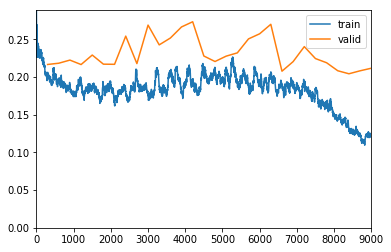

Epoch 2: reducing lr to 1.1271120676249444e-05
Epoch 3: reducing lr to 1.5307564878916467e-05
Epoch 5: reducing lr to 2.783807933204143e-05
Epoch 6: reducing lr to 3.611774900609144e-05
Epoch 7: reducing lr to 4.555890281516284e-05
Epoch 8: reducing lr to 5.600000000000002e-05
Epoch 9: reducing lr to 6.726239049295139e-05
Epoch 10: reducing lr to 7.915337167015804e-05
Epoch 11: reducing lr to 9.146948554687506e-05
Epoch 12: reducing lr to 0.00010400000000000002
Epoch 13: reducing lr to 0.00011653051445312495
Epoch 14: reducing lr to 0.00012884662832984205
Epoch 15: reducing lr to 0.00014073760950704864
Epoch 16: reducing lr to 0.000152
Epoch 17: reducing lr to 0.00016244109718483723
Epoch 18: reducing lr to 0.00017188225099390862
Epoch 19: reducing lr to 0.00018016192066795862
Epoch 20: reducing lr to 0.00018713843876330617
Epoch 21: reducing lr to 0.0001926924351210836
Epoch 23: reducing lr to 0.00019917870669188586
Epoch 24: reducing lr to 0.00020000000000000006
Epoch 25: reducing lr

In [52]:
learn_b2u.fit_one_cycle(30, slice(1e-6,1e-3), pct_start=0.8)

# Model 3

## Train 1

In [33]:
data = get_data(src_size,2)

In [34]:
learn_3 = unet_learner(data, models.resnet34, metrics=acc_camvid,
                     wd=1e-3, bottle=True, path='D:/programming/projects/camvid/',
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='3'),
                                 ShowGraph])

In [35]:
learn_3.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


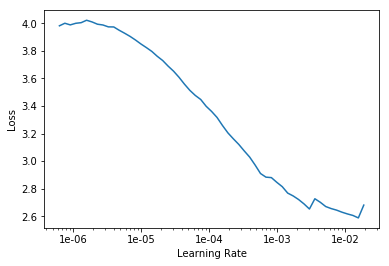

In [38]:
lr_find(learn_3)
learn_3.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid
1,0.608874,0.529319,0.856701
2,0.498262,0.414701,0.884828
3,0.436201,0.334562,0.902984
4,0.399272,0.385766,0.890980
5,0.371259,0.279721,0.923711
6,0.348399,0.290400,0.913512
7,0.360908,0.333912,0.920718
8,0.338318,0.248327,0.925883
9,0.312078,0.428286,0.893185
10,0.269372,0.273431,0.918955


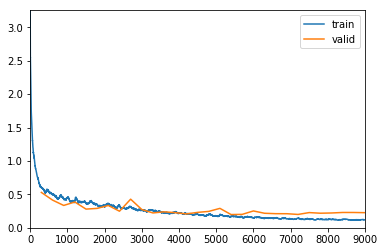

In [36]:
learn_3.fit_one_cycle(30, slice(1e-6,1e-3))

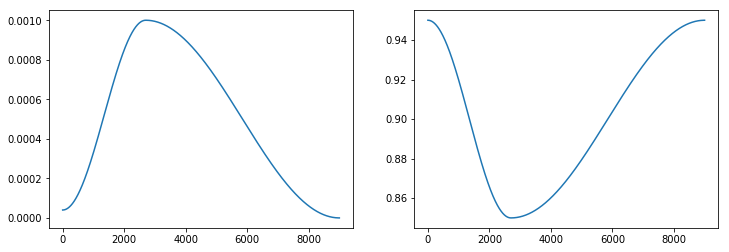

In [37]:
learn_3.recorder.plot_lr(show_moms=True)

# Results

In [30]:
data = get_data(src_size,2)

In [31]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid,
                     wd=1e-3, bottle=True, path='D:/programming/projects/camvid/',
                    callback_fns=[partial(SaveModelCallback,every='epoch',name='3'),
                                 ShowGraph])

In [32]:
learn.load(weights2/'3_24');

best model summary

In [38]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [2, 64, 360, 480]    9408       False     
______________________________________________________________________
BatchNorm2d          [2, 64, 360, 480]    128        True      
______________________________________________________________________
ReLU                 [2, 64, 360, 480]    0          False     
______________________________________________________________________
MaxPool2d            [2, 64, 180, 240]    0          False     
______________________________________________________________________
Conv2d               [2, 64, 180, 240]    36864      False     
______________________________________________________________________
BatchNorm2d          [2, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [2, 64, 180, 240]    0          False     
______________________________________________________________

______________________________________________________________________
ReplicationPad2d     [2, 192, 181, 241]   0          False     
______________________________________________________________________
AvgPool2d            [2, 192, 180, 240]   0          False     
______________________________________________________________________
ReLU                 [2, 768, 90, 120]    0          False     
______________________________________________________________________
BatchNorm2d          [2, 64, 180, 240]    128        True      
______________________________________________________________________
Conv2d               [2, 256, 180, 240]   590080     True      
______________________________________________________________________
ReLU                 [2, 256, 180, 240]   0          False     
______________________________________________________________________
Conv2d               [2, 256, 180, 240]   590080     True      
_______________________________________________________

Results:

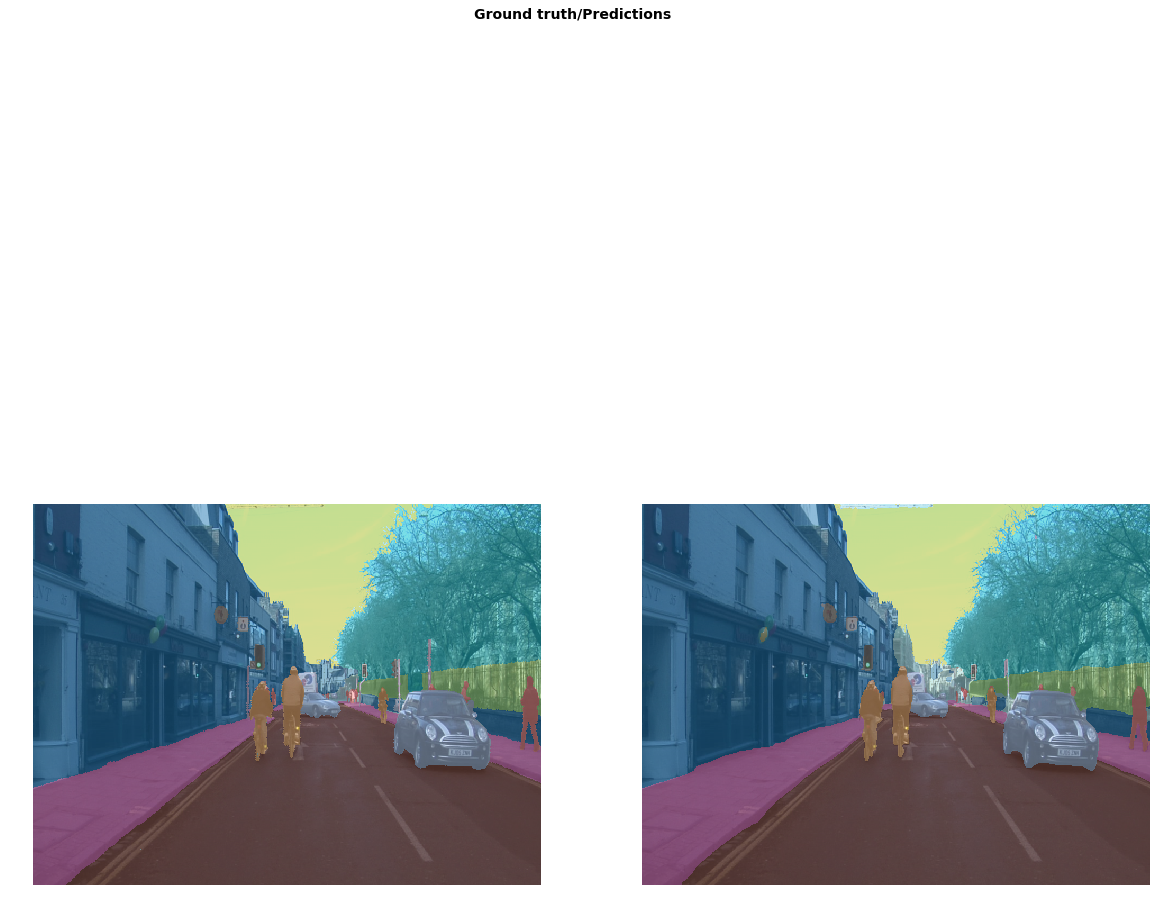

In [35]:
learn.show_results(rows=1,figsize=(20,20))

# End